Import libraries and dependencies

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-JPY Exchange rate data.

Currency pair exchange rates for CAD/JPY

In [31]:
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True)

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


Trimming the dataset to begin on January 1st, 1990

In [32]:
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]

cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

Plotting the "Settle" price from our above dataframe.

<AxesSubplot:title={'center':'Evolution of CAD/JPY FX'}, xlabel='Date', ylabel='CAD/JPY'>

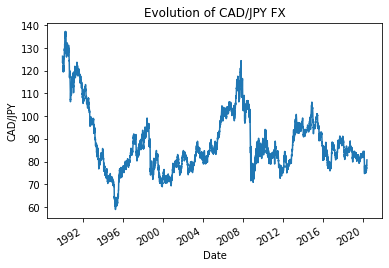

In [35]:
cad_jpy_df["Price"].plot(kind='line', ylabel='CAD/JPY', title= "Evolution of CAD/JPY FX")

- Note: Despite periods of significant fluctuation we can appreciate that the JPY has tended to appreciate against the CAD over time.

---

# Decomposition Using a Hodrick-Prescott Filter

In [36]:
import statsmodels.api as sm

fx_noise, fx_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [37]:
cad_jpy_df_1= cad_jpy_df["Price"].to_frame()

cad_jpy_df_1["Trend"]=fx_trend

cad_jpy_df_1["Noise"]= fx_noise

cad_jpy_df_1

,Price,Trend,Noise
Date,,,
1990-01-02,126.37,125.850905,0.519095
1990-01-03,125.30,125.679684,-0.379684
1990-01-04,123.46,125.508788,-2.048788
1990-01-05,124.54,125.338304,-0.798304
1990-01-08,124.27,125.167037,-0.897037
...,...,...,...
2020-05-29,78.29,78.793961,-0.503961
2020-06-01,79.27,79.051061,0.218939
2020-06-02,80.40,79.311883,1.088117


Plotting the Exchange Rate Price vs. the Trend for 2015 to the present

<AxesSubplot:title={'center':'Canadian dollar to Japanese Yen'}, xlabel='Date', ylabel='CAD/JPY'>

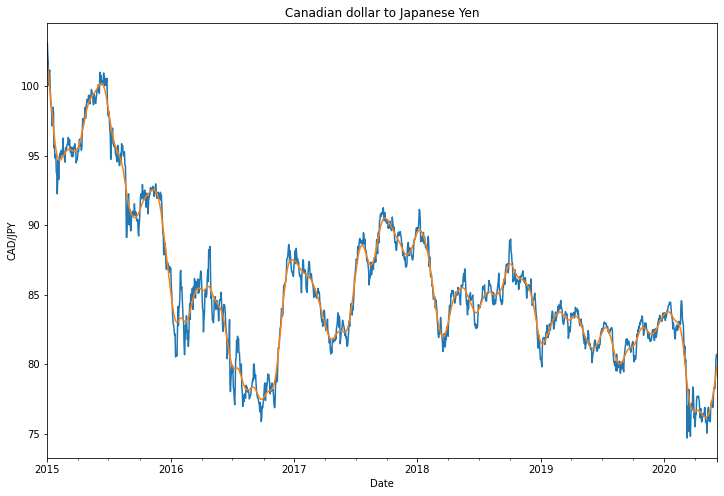

In [38]:
cad_jpy_df_1["Price"].loc["2015":].plot(title= "Canadian dollar to Japanese Yen",ylabel="CAD/JPY", figsize=(12,8))

cad_jpy_df_1["Trend"].loc["2015":].plot()


- Note: The trend and price plots allows us to visualize a clear tendency of the Japanese Yen to appreciate versus the Canadian dollar. If we isolate the subperiod starting in 2017, we can also appreciate that the FX between the two currencies has remain relatively stable tending to stay within the ¥80-90 JPY per CAD range.

Plotting the Settle Noise

<AxesSubplot:title={'center':'CAD/JPY Price Noise'}, xlabel='Date'>

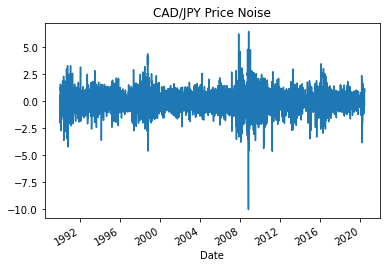

In [39]:
cad_jpy_df_1["Noise"].plot(title= 'CAD/JPY Price Noise')

---

# Forecasting Returns using an ARMA Model

Estimating an ARMA model using exchange rate *Returns*,

**Transforming the data to make it stationary**

In [40]:
returns = (cad_jpy_df[["Price"]].pct_change()*100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.rename(columns={"Price": "Daily returns"}, inplace=True)
returns.head()

,Daily returns
Date,
1990-01-03,-0.846720
1990-01-04,-1.468476
1990-01-05,0.874777
1990-01-08,-0.216798
1990-01-09,0.667901


Estimating an ARMA model using statsmodels using two lags for our RA component and one for our MA component

In [42]:
model = ARMA(returns.values, order=(2,1))

results = model.fit()

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sun, 30 Jan 2022   AIC                          19513.955
Time:                        19:27:08   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1704           +0.0000j           42.1704            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

Plotting the 5 Day Returns Forecast

<AxesSubplot:title={'center':'CAD/JPY Return Forecast'}>

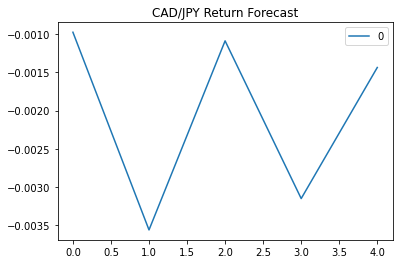

In [43]:
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="CAD/JPY Return Forecast")

- Note: Based on p-values, only the first order is statistically significant. So the model is better off as a (1,1) model.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

Estimating an ARIMA model using the CAD/JPY exchange rate price.

The model will use 5 lags for our AR component, 1 for the differences, and one for our moving average component


In [44]:
model_arima = ARIMA(returns.values, order=(5, 1, 1))

results_arima = model_arima.fit()

In [45]:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7927
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -9754.047
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sun, 30 Jan 2022   AIC                          19524.095
Time:                        19:30:07   BIC                          19579.919
Sample:                             1   HQIC                         19543.211
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.765e-06    3.9e-06      0.709      0.478   -4.88e-06    1.04e-05
ar.L1.D.y     -0.0305      0.011     -2.714      0.007      -0.052      -0.008
ar.L2.D.y     -0.0030      0.011     -0.264      0.792      -0.025       0.019
ar.L3.D.y     -0.0096      0.011     -0.851      0.394      -0.032       0.012
ar.L4.D.y      0.0016      0.011      0.144      0.885      -0.020       0.024
ar.L5.D.y     -0.0184      0.011     -1.633      0.102      -0.040       0.004
ma.L1.D.y     -0.9999      0.000  -2382.126      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1386           -0.0000j            2.1386           -0.5000
AR.2            1.7867           -1.3698j            2.2514           -0.1041
AR.3            1.7867           +1.3698j            2.2514            0.1041
AR.4           -0.6733           -2.1386j            2.2421           -0.2985
AR.5           -0.6733           +2.1386j            2.2421            0.2985
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

Plotting the 5 Day Price Forecast

<AxesSubplot:title={'center':'CAD/JPY Return Forecast'}>

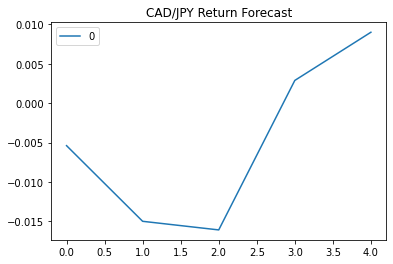

In [46]:
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="CAD/JPY Return Forecast")

### What does the model forecast will happen to the Japanese Yen in the near term?

The ARIMA model predicts the JPY will experience a net depreciation in value against the CAD in the near term. The positive return on the chart's y-axis unintuively signals an increase in value of the CAD vs JPY. That is, more JPY will be needed per CAD, thus the 'returns' calculation becomes positive.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.


In [47]:
model_garch = arch_model(returns['Daily returns'], mean="Zero", vol="GARCH", p=2, q=1)

results_garch = model_garch.fit(disp="off")

In [49]:
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:          Daily returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sun, Jan 30 2022   Df Residuals:                     7928
Time:                        19:31:11   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

Let's create a 5 day forecast of volatility

In [50]:
last_day = returns.index.max().strftime('%Y-%m-%d')

last_day

'2020-06-04'

In [20]:
forecast_horizon = 5

forecast_garch=results_garch.forecast(start=last_day, horizon=forecast_horizon)

forecast_garch

Annualizing the forecast

In [51]:
intermediate = np.sqrt(forecast_garch.variance.dropna() * 252)

intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


Transposing the forecast so that it is easier to plot

In [54]:
final = intermediate.dropna().T

final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

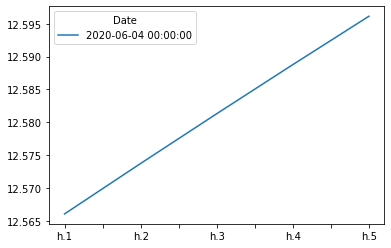

In [55]:
final.plot()

From our figure above, we can conclude that our GARCH model predicts that volatility of the CAD/JPY FX will increase over the forecasted 5 days period.

---

# Conclusions

1. Based on the time series analysis, would you buy the yen now?

    * Both our short term returns and volatility forecasts suggests it would not be wise to convert Canadian dollar to Japanese Yen at this time.

2. Is the risk of the yen expected to increase or decrease?
    * In looking on our volatility forecast, the risk attached to the Yen is expected to increase as volatility is predicted to increase over the short-term.

3. Based on the model evaluation, would you feel confident in using these models for trading?
  * Our GARCH model seems to be more reliable compared to our returns predicting models. Therefore we can use it to trade in instruments that price in volality such as FX options.
    